<a href="https://colab.research.google.com/github/Xenonimous/MyBangkitCapstone/blob/master/Better_MobileNetV2Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking Tensorflow version (Optional)


Before running the shell please make sure that you have changed Runtime 
Type into GPU



In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

Importing Libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random

from google.colab import files

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.5.0


Installing kaggle to colab

In [ ]:
! pip install -q kaggle

Importing Files to colab with kaggle.json

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rianm2482358","key":"f247ba600cae259f51821a4c1e959d9e"}'}

Making kaggle directory

In [ ]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

Downloading Garbage Classification dataset from Kaggle

In [ ]:
! kaggle datasets download -d asdasdasasdas/garbage-classification

 90% 74.0M/82.0M [00:02<00:00, 27.1MB/s]
100% 82.0M/82.0M [00:02<00:00, 37.9MB/s]


Unzipping the dataset

In [ ]:
! unzip garbage-classification.zip -d temp
! mv temp/Garbage\ classification/Garbage\ classification .
! rm -r temp
! mv Garbage\ classification datasets



Streaming output truncated to the last 5000 lines.
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: temp/Ga

Splitting Training, Testing, and Validation dataset

In [ ]:
#Download and Install split_folders package
! pip install split-folders

In [ ]:
#Split datasets into new folder
import splitfolders
splitfolders.ratio('/content/datasets/', output="datasplit", seed=1337, ratio=(0.7, 0.15,0.15))

Copying files: 2527 files [00:00, 5521.65 files/s]


Generating data for training, testing, and validating

In [ ]:
train_dir = '../content/datasplit/train/'
test_dir = '../content/datasplit/test/'
val_dir = '../content/datasplit/val/'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (224, 224)
    )

test_generator = datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (224, 224)
    )

validation_generator = datagen.flow_from_directory(
    val_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (224, 224)
    )

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


Transfer Learning : Inception V3

In [ ]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95 or logs.get('val_accuracy')>0.90):
#             print("\nCanceling Training: Accuracy Reached 95% or Validation Accuracy Reached 90%")
#             self.model.stop_training = True

# callbacks=myCallback()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'check_point_model.hdf5',
    verbose=1,
    save_best_only=True)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
predictions = tf.keras.layers.Dense(6, activation="softmax")(x)

model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=predictions
    )

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 32,
    epochs = 100,
    verbose = 1,
    validation_steps = 5,
    callbacks=[model_checkpoint,early_stop]
    )

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/100
32/32 [==============================] - 48s 531ms/step - loss: 1.0912 - accuracy: 0.5986 - val_loss: 0.6134 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.61340, saving model to check_point_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
32/32 [==============================] - 16s 500ms/step - loss: 0.6725 - accuracy: 0.7545 - val_loss: 0.5294 - val_accuracy: 0.8250

Epoch 00002: val_loss improved from 0.61340 to 0.52942, saving model to check_point_model.hdf5
Epoch 3/100
32/32 [==============================] - 16s 499ms/step - loss: 0.5794 - accuracy: 0.7856 - val_loss: 0.6773 - val_accuracy: 0.7750

Epoch 00003: val_loss did not improve from 0.52942
Epoch 4/100
32/32 [==============================] - 16s 495ms/step - loss: 0.6250 - accuracy: 0.7756 - val_loss: 0.5764 - val_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.52942
Epoch 5/100
32/32 [==============================] - 16s 491ms/step - loss: 0.5301 - accuracy: 0.8026 - val_loss: 0.6137 - val_accuracy: 0.7688

Epoch 00005: val_loss did not improve from 0.52942
Epoch 6/100
32/32 [==============================] - 16s 510ms/step - loss: 0.4773 - accuracy: 0.8135 - val_loss: 0.3794 - val_accuracy: 0.8562

Epoch 00006: val_loss impro

Save model

In [ ]:
model.save('mobilenetv2_model.h5')
# tf.saved_model.save(model,'../content/')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Evaluate the model

In [ ]:
model.evaluate(test_generator, steps = 10)

10/10 [==============================] - 2s 150ms/step - loss: 0.4575 - accuracy: 0.8562


[0.4574958384037018, 0.856249988079071]

Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Accuracy and Loss Plot

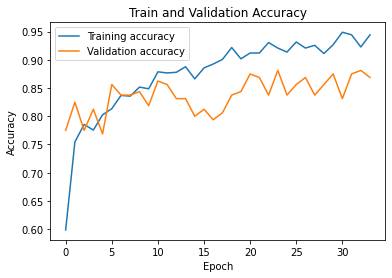

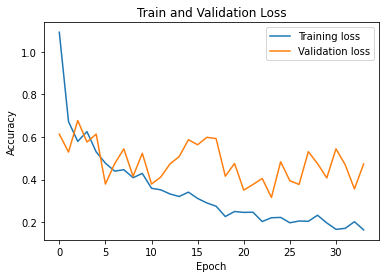

In [ ]:
#Accuracy plot
plt.title("Train and Validation Accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.legend(["Training accuracy","Validation accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

#Loss plot
plt.title("Train and Validation Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss","Validation loss"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Test the model

Saving plastic.jpg to plastic.jpg


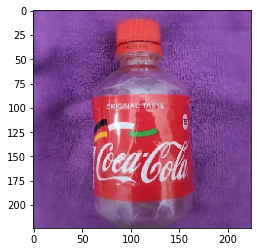

Cardboard: 0.02%
Glass: 5.03%
Metal: 0.95%
Paper: 0.01%
Plastic: 93.48%
Trash: 0.51%


In [ ]:
from keras_preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

uploaded = files.upload()
labels = train_generator.class_indices.keys()

for name in uploaded.keys():
    path = name
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    probability = model.predict(images)[0]
    for (label, p) in zip(labels, probability):
        print("{}: {:.2f}%".format(label.capitalize(), p * 100))


Checking Model Size (Optional)

In [ ]:
print (str(os.path.getsize('mobilenetv2_model.h5')/1024**2) + ' MB')

16.62555694580078 MB


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenetv2_model.tflite', 'wb') as f:
  f.write(tflite_model)

# saved_model_dir = '../content/'
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# with open('saved_model.tflite', 'wb') as f:
#   f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpc085ajhe/assets


In [ ]:
print (str(os.path.getsize('mobilenetv2_model.tflite')/1024**2) + ' MB')

10.962783813476562 MB


In [ ]:
new_model = tf.keras.models.load_model('mobilenetv2_model.h5')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________